# Markov Chain, Metropolis-Hastings, Bayesian Logistic Regression Model


## 1. Markov Chain 

Consider a *discrete Markov Chain* with transition matrix $\pmb{P}=\begin{bmatrix}0.6 & 0.4 \\ 0.2 & 0.8 \end{bmatrix}$. Verify that the *stationary distribution* is $\pmb{\pi}=\begin{bmatrix} 1/3 \\ 2/3 \end{bmatrix}$. More generally, the stationary distribution is proportional to the eigen-vector of $\pmb{P^T}$ corresponding to eigen-value 1.

### 1.1 Simulation from MC
1. Write your own code to simulate 2000 values from the discrete Markov Chain of theory question 3 above, starting at the first state. Then calulate the sample frequncies of the two states, and compare them to their stationary distribution.

In [1]:
import numpy as np

# Transition matrix
P = np.array([[0.6, 0.4],
              [0.2, 0.8]])

states = [0]; n_steps = 2000
for i in range(n_steps):
    current_state = states[i]
    next_state = np.random.choice([0, 1], p=P[current_state])
        # Randomly selects next state based on current transition probabilities.
        # The transition probability determined by the row in transition matrix P corresponding to current state.
    states.append(next_state)

# Calculate sample frequencies
unique, counts = np.unique(states, return_counts=True)
sample_frequencies = counts / n_steps

print("Sample Frequencies:", sample_frequencies)

Sample Frequencies: [0.3465 0.654 ]


In [2]:
import numpy as np
eigenvalues, eigenvectors = np.linalg.eig(P.T)
eigenvector_1 = eigenvectors[:, np.isclose(eigenvalues, 1)]
print("Stationary distribution is proportional to:\n",eigenvector_1) ; 
stationary_dist = np.array([1/3,2/3])
print("Here proportion value is:\n",eigenvector_1.T/stationary_dist)

Stationary distribution is proportional to:
 [[-0.4472136 ]
 [-0.89442719]]
Here proportion value is:
 [[-1.34164079 -1.34164079]]


## 2. Metropolis-Hastings algorithm (standard Gaussian proposal kernel)
### 2.1 Sampling & Plot 
2. Consider the mixture of two Normals $0.4 \times \mathcal{N}(0,1) + 0.6 \times \mathcal{N}(3,1/4)$. Note that the density of the mixture is $f(x) = 0.4 \phi(x) + 0.6 \phi( 2(x-3) )$, where $\phi()$ is the standard Normal PDF. Implement from scratch a Metropolis-Hastings algorithm with a standard Gaussian proposal kernel (proposal distribution, which is symmetric) $q(x'|x) = \frac{1}{\sqrt{2\pi}} \exp\left\{  -(x'-x)^2/2 \right\}$. Generate 1000 samples starting from 0, and plot their histogram and the true density on the same axis

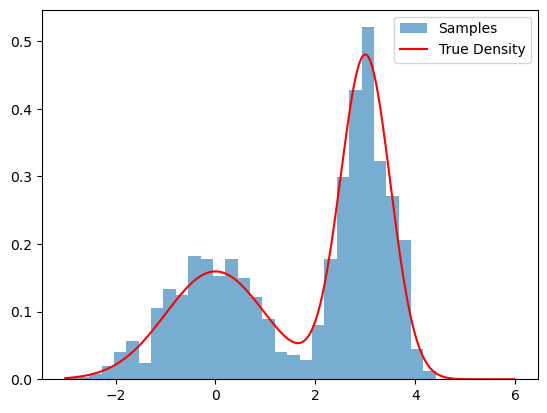

In [3]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

# Define the target density function
def target_density(x):
    return 0.4 * norm.pdf(x, 0, 1) + 0.6 * norm.pdf(x, 3, 0.5)

# Metropolis-Hastings algorithm
n_samples = 1000
current_x = 0; samples = [current_x]

for _ in range(n_samples - 1):
    proposed_x = np.random.normal( current_x, 1 )
    acceptance_ratio = target_density(proposed_x) / target_density(current_x)   
    if np.random.rand() < acceptance_ratio:
        current_x = proposed_x
    samples.append(current_x)

# Plot histogram of samples and true density
plt.hist(samples, bins=30, density=True, alpha=0.6, label='Samples')
x = np.linspace(-3, 6, 1000)
plt.plot(x, target_density(x), 'r', label='True Density')
plt.legend(); plt.show()

## 3. Bayesian Logistic Regression Model

3. For this question you will try to fit a *Bayesian* logistic regression model to the familiar Wisconsin Diagnostic Breast Cancer data. The following code loads the data and defines a PGM for a logistic regression with two features (`radius_m` and `fractal_dimension_m`) with diffuse Normal priors for their coefficients:
$$ \beta_0, \beta_1, \beta_2 \sim^{i.i.d.} \mathcal{N}(0,100) ,\quad  \mu = \beta_0 + \beta_1 x_1 + \beta_2 x_2 \\
p = \text{logit}^{-1}(\mu) = \frac{ \exp(\mu ) }{ 1+\exp(\mu) } , \quad y \sim \text{Bernoulli}(p)$$ 
where p is function of x1 and x2 (Note: we *standardize* the features because their scale is very different: radius is ~ 15 and fractal dim is ~ 0.05)

/opt/conda/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


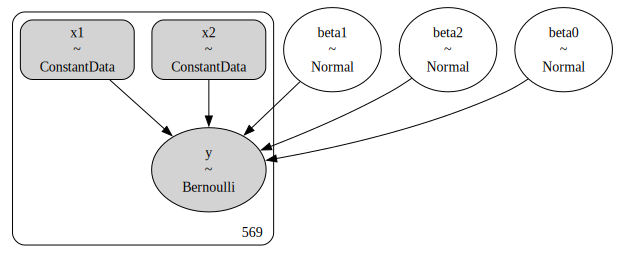

In [4]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

tmp = load_breast_cancer() # load dictinary of 'target' (y) and 'data' (X)  variables
y = tmp['target'] # diagnosis: 0 = malignant , 1 = benign tumor
X = tmp['data'][:,[0,9]] # features: radius_m & fractal_dimension_m
X = StandardScaler().fit_transform(X) # stndardize features

import pymc as pm
with pm.Model() as pm_GLM:
    x1 = pm.Data("x1", X[:,0] ); x2 = pm.Data("x2", X[:,1] )
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)
    # linear model
    mu = beta0 + beta1 * x1 + beta2 * x2
    p = np.exp(mu) / ( 1 + np.exp(mu) )
    # likelihood
    pm.Bernoulli("y", p=p, observed=y )

pm.model_to_graphviz(pm_GLM)

### 3.1 Fit Regular logistic regression
#### a. sklearn
Fit a regular logistic regression with `sklearn`, and report the coefficient estimates.

In [5]:
from sklearn.linear_model import LogisticRegression

# Fit logistic regression model
log_reg = LogisticRegression().fit(X, y)

# Print the coefficient estimates
print("Intercept:", log_reg.intercept_)
print("Coefficients:", log_reg.coef_)

Intercept: [0.62043773]
Coefficients: [[-4.11363792 -1.1465355 ]]


#### b. statsmodels
Alternatively you can fit the LR model with the "statsmodels" package which gives more detailed output, similar to R

In [6]:
import statsmodels.api as sm

# Add a constant (intercept) to the features matrix
X_with_const = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X_with_const).fit()

# Print the summary of the model, which includes the confidence intervals
print('\n\n ----- with Statsmodels  -----\n\n' )
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.229367
         Iterations 8


 ----- with Statsmodels  -----


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  569
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            2
Date:                Sat, 05 Apr 2025   Pseudo R-squ.:                  0.6526
Time:                        21:53:16   Log-Likelihood:                -130.51
converged:                       True   LL-Null:                       -375.72
Covariance Type:            nonrobust   LLR p-value:                3.210e-107
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6282      0.160      3.921      0.000       0.314       

### 3.2. MCMC 

Use MCMC to draw samples of size 1000 from the posterior of the parameters, plot them, and calculate their means. Recall  `pm.sample()` function employs MCMC to draw samples from the *posterior* distribution of the latent variables and/or random parameters (Bayesian stats), given the data. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.637,0.165,0.325,0.942,0.003,0.003,3159.0,2304.0,1.0
beta1,-4.904,0.447,-5.787,-4.129,0.009,0.007,2408.0,2446.0,1.0
beta2,-1.366,0.184,-1.714,-1.032,0.004,0.003,2294.0,2651.0,1.0


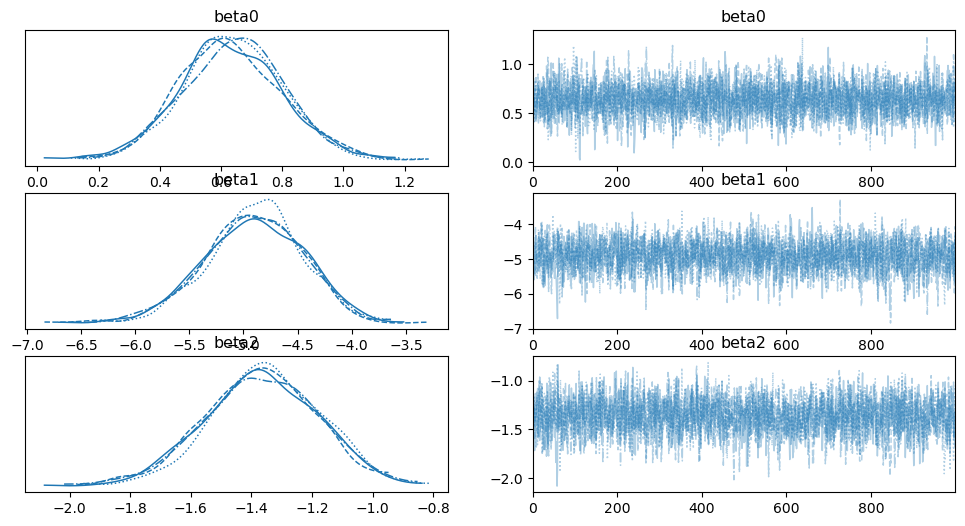

In [7]:
with pm_GLM:
    trace = pm.sample(draws = 1000, random_seed=123) 
    
pm.plot_trace(trace, var_names=['beta0', 'beta1', 'beta2'])
pm.summary(trace, var_names=['beta0', 'beta1', 'beta2'])

# Note that beta_0 and beta_1 are significantly different from zero, while beta_2 is not.
# That holds for the frequentist logistic regression model as well.

### 3.3. variational approximation to the posterior

Create a variational approximation to the posterior, draw 1000 samples from it, and calculate their means. 

Finished [100%]: Average Loss = 142.47
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.636,0.166,0.359,0.949,0.005,0.004,1010.0,996.0,NaN
beta1,-4.877,0.368,-5.509,-4.117,0.012,0.008,960.0,912.0,NaN
beta2,-1.352,0.159,-1.647,-1.059,0.006,0.004,827.0,729.0,NaN


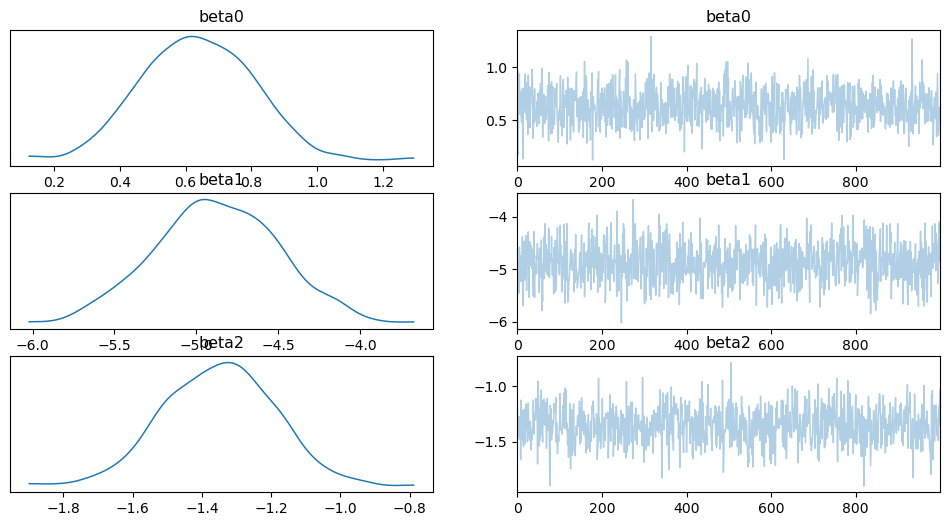

In [8]:
with pm_GLM:
    vi_approx = pm.fit(50000, method='advi', random_seed=123)
    vi_trace = vi_approx.sample(1000)

pm.plot_trace(vi_trace)
pm.summary(vi_trace)